### IMPORTS

In [1]:
!pip install -q scikit-optimize

In [2]:
!pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable
  Using cached category_encoders-2.5.0-py2.py3-none-any.whl (69 kB)
     ---------------------------------------- 9.1/9.1 MB 7.0 MB/s eta 0:00:00
     ------------------------------------- 233.7/233.7 kB 14.9 MB/s eta 0:00:00


In [3]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [10]:
import os
import math
import timeit
from collections import Counter
import gc
import pickle

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import category_encoders as ce

from sklearn import metrics, tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from IPython.display import display, display_html
import xgboost as xgb

ModuleNotFoundError: No module named 'seaborn'

### UDFs

In [ ]:
def my_print(s):
    """
    Custom print with timestamp.
    """
    print("[{}] {}".format(datetime.now().strftime('%d/%m/%Y %H:%M:%S'), s))

In [ ]:
def get_missing_values(pdf):
        """
        Retorna um Pandas Series com as colunas que tem ao
        menos um missing value.
        """
        
        missing = pdf.isnull().sum()
        return missing[missing > 0]

### LOAD DATA

In [13]:
df = pd.read_csv("Documents/Deploy2/pi-predicao-churn/data/Churn Modeling.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Documents/Deploy2/pi-predicao-churn/data/Churn Modeling.csv'

In [ ]:
df.shape

In [ ]:
get_missing_values(df)

In [12]:
df

NameError: name 'df' is not defined

In [ ]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [ ]:
df

In [ ]:
var_cat = ['Geography','Gender']

In [ ]:
var_num = ['CreditScore','Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary','HasCrCard','IsActiveMember']

In [ ]:
var_target = ['Exited']

In [ ]:
features = list(var_cat + var_num)

In [ ]:
df.info()

In [ ]:
features

In [ ]:
X = df[features]
y = df[var_target]

### Spliting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [ ]:
len(X), len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
X_train

### Categorização

#### Target Enconder
    

In [ ]:
target_enconder = ce.TargetEncoder(
    cols=var_cat,
    verbose=10
)
target_enconder.fit(X,y)

In [ ]:
X_train = target_enconder.transform(X_train)
X_test = target_enconder.transform(X_test)

#### OneHot Enconder

In [ ]:
onehot_enconder = ce.OneHotEncoder(cols=var_cat)
onehot_enconder.fit(X_train)

In [ ]:
X_train_OHE = onehot_enconder.transform(X_train)
X_test_OHE = onehot_enconder.transform(X_test)

### Padronização

In [ ]:
mm_scaler = MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train[var_num])
X_test_mm = mm_scaler.transform(X_test[var_num])

In [ ]:
X_train_mm

In [ ]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train[var_num])
X_test_ss = ss.transform(X_test[var_num])

In [ ]:
X_train_ss

### Final Dataset

In [ ]:
X_train_scaled = pd.DataFrame(X_train_ss, index = X_train[var_num].index, columns = X_train[var_num].columns)
X_test_scaled = pd.DataFrame(X_test_ss, index = X_test[var_num].index, columns = X_test[var_num].columns)

In [ ]:

X_test_scaled 

In [ ]:
X_train[var_cat]

In [ ]:
Xs_train = pd.concat([X_train_scaled, X_train[var_cat]], axis=1)
Xs_test = pd.concat([X_test_scaled, X_test[var_cat]], axis=1)

In [ ]:
Xs_test

In [ ]:
y_train = y_train.Exited
y_test = y_test.Exited

In [ ]:
y_train

### Regressão Logística

In [ ]:
stime = timeit.default_timer()
clr = LogisticRegression(random_state=45678, solver='lbfgs', n_jobs=-1, penalty = "none")
clr.fit(Xs_train, y_train)

etime = timeit.default_timer()
lr_baseline_time = etime - stime
print(f'Speed: {lr_baseline_time:.2f}s')
print(f'AUC train: {metrics.roc_auc_score(y_train, clr.predict_proba(Xs_train)[:, 1]):.2f}')
print(f'AUC test: {metrics.roc_auc_score(y_test, clr.predict_proba(Xs_test)[:, 1]):.2f}')
print(f'ACC train: {metrics.accuracy_score(y_train, clr.predict(Xs_train)):.2f}')
print(f'ACC test: {metrics.accuracy_score(y_test, clr.predict(Xs_test)):.2f}')
print(f'f1 score train: {metrics.f1_score(y_train, clr.predict(Xs_train)):.2f}')
print(f'f1 score test: {metrics.f1_score(y_test, clr.predict(Xs_test)):.2f}')

In [ ]:
y_pred = clr.predict(Xs_train)

In [ ]:
conma = metrics.confusion_matrix(y_test, clr.predict(Xs_test))
conma

In [ ]:
metrics.ConfusionMatrixDisplay(conma).plot()

#### Cross Validation

In [ ]:
scores = cross_val_score(clr, Xs_train, y_train, cv =10)
AUC = cross_val_score(clr, Xs_train, y_train, cv =10, scoring = 'roc_auc')
f1 = cross_val_score(clr, Xs_train, y_train, cv =10, scoring = 'f1')

In [ ]:
scorings = ['f1', 'accuracy', 'roc_auc']

In [ ]:
f1 = cross_validate(clr, Xs_train, y_train, cv =10, scoring = scorings)

In [ ]:
sorted(f1.keys())

In [ ]:
y_pred = clr.predict(Xs_test)

In [ ]:
AUC.mean()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

### Random Forest

In [ ]:
stime = timeit.default_timer()

rf_clf = RandomForestClassifier(
    n_estimators=294,
    criterion='entropy',
    max_depth=10,
    min_samples_split = 7,
    min_samples_leaf = 4,
    max_samples = 0.673861043631317,
    max_features='sqrt',
    random_state= 0
)

rf_clf.fit(Xs_train, y_train)

etime = timeit.default_timer()

rf_clf_baseline_time = etime - stime
rf_clf_y_train_predict = rf_clf.predict_proba(Xs_train)[:, 1]

print(f'Speed: {rf_clf_baseline_time:.2f}s')
print(f'AUC train: {roc_auc_score(y_train, rf_clf_y_train_predict):.2f}')
print(f'AUC test: {metrics.roc_auc_score(y_test, rf_clf.predict_proba(Xs_test)[:, 1]):.2f}')
print(f'f1 score train: {metrics.f1_score(y_train, rf_clf.predict(Xs_train)):.2f}')
print(f'f1 score test: {metrics.f1_score(y_test, rf_clf.predict(Xs_test)):.2f}')

In [ ]:
conma = metrics.confusion_matrix(y_test, rf_clf.predict(Xs_test))
conma

In [ ]:
metrics.ConfusionMatrixDisplay(conma).plot()

### Gradient Boosting

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
...     max_depth=2, random_state=0).fit(Xs_train, y_train)
>>> gbc.score(Xs_test, y_test)
gb_clf_y_train_predict = gbc.predict_proba(Xs_train)[:, 1]

print(f'AUC train: {roc_auc_score(y_train, gb_clf_y_train_predict):.2f}')
print(f'AUC test: {metrics.roc_auc_score(y_test, gbc.predict_proba(Xs_test)[:, 1]):.2f}')
print(f'ACC train: {metrics.accuracy_score(y_train, gbc.predict(Xs_train)):.2f}')
print(f'ACC test: {metrics.accuracy_score(y_test, gbc.predict(Xs_test)):.2f}')
print(f'f1 score train: {metrics.f1_score(y_train, gbc.predict(Xs_train)):.2f}')
print(f'f1 score test: {metrics.f1_score(y_test, gbc.predict(Xs_test)):.2f}')

### XGBoosting

In [9]:
classificador_xgb = xgb.XGBClassifier()

NameError: name 'xgb' is not defined

In [ ]:
type(classificador_xgb)

In [ ]:
from sklearn.model_selection import cross_val_score

resultado_cv = cross_val_score(classificador_xgb, Xs_train, y_train)
resultado_cv

In [ ]:
resultado_cv.mean()

In [ ]:
classificador_xgb_tunado = xgb.XGBClassifier(max_depth=2, eta= 0.35)
100 * cross_val_score(classificador_xgb_tunado, Xs_train, y_train).mean()

In [ ]:
classificador_xgb_dart = xgb.XGBClassifier(booster='dart')
100 * cross_val_score(classificador_xgb_dart, Xs_train, y_train).mean()

In [ ]:
classificador_xgb_gblinear = xgb.XGBClassifier(booster='gblinear')
100 * cross_val_score(classificador_xgb_gblinear, Xs_train, y_train).mean()

In [ ]:
classificador_campeao = classificador_xgb_tunado

In [5]:
classificador_campeao.fit(Xs_train, y_train)

NameError: name 'classificador_campeao' is not defined

In [6]:
xgb_y_train_predict = classificador_campeao.predict_proba(Xs_train)[:, 1]


print(f'AUC train: {roc_auc_score(y_train, xgb_y_train_predict):.2f}')
print(f'AUC test: {metrics.roc_auc_score(y_test, classificador_campeao.predict_proba(Xs_test)[:, 1]):.2f}')
print(f'ACC train: {metrics.accuracy_score(y_train, classificador_campeao.predict(Xs_train)):.2f}')
print(f'ACC test: {metrics.accuracy_score(y_test, classificador_campeao.predict(Xs_test)):.2f}')
print(f'f1 score train: {metrics.f1_score(y_train, classificador_campeao.predict(Xs_train)):.2f}')
print(f'f1 score test: {metrics.f1_score(y_test, classificador_campeao.predict(Xs_test)):.2f}')

NameError: name 'classificador_campeao' is not defined

In [7]:
conma = metrics.confusion_matrix(y_test, classificador_campeao.predict(Xs_test))
conma

NameError: name 'metrics' is not defined

In [8]:
metrics.ConfusionMatrixDisplay(conma).plot()

NameError: name 'metrics' is not defined

### Naive Bayes

In [151]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [153]:
gnb.fit(Xs_train, y_train)
gnb_y_train_predict = gnb.predict_proba(Xs_train)[:, 1]


print(f'AUC train: {roc_auc_score(y_train, gnb_y_train_predict):.2f}')
print(f'AUC test: {metrics.roc_auc_score(y_test, gnb.predict_proba(Xs_test)[:, 1]):.2f}')
print(f'ACC train: {metrics.accuracy_score(y_train, gnb.predict(Xs_train)):.2f}')
print(f'ACC test: {metrics.accuracy_score(y_test, gnb.predict(Xs_test)):.2f}')
print(f'f1 score train: {metrics.f1_score(y_train, gnb.predict(Xs_train)):.2f}')
print(f'f1 score test: {metrics.f1_score(y_test, gnb.predict(Xs_test)):.2f}')

AUC train: 0.80
AUC test: 0.80
ACC train: 0.83
ACC test: 0.83
f1 score train: 0.43
f1 score test: 0.46


In [155]:
conma = metrics.confusion_matrix(y_test, gnb.predict(Xs_test))
conma

array([[1877,  114],
       [ 323,  186]], dtype=int64)

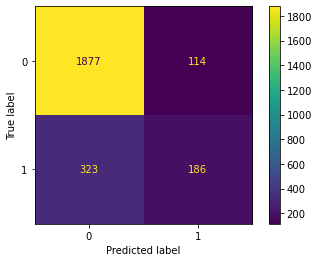

In [156]:
metrics.ConfusionMatrixDisplay(conma).plot()

### Otimização de Hiperparâmetros

In [197]:
from sklearn.model_selection import GridSearchCV
# mudar de acordo com o modelo encontrado
pipeline = GridSearchCV(classificador_xgb, hiperparameters)
hiperparameters = {'booster':('gblinear', 'dart', 'gbtree')}
pipeline.fit(Xs_train, y_train)
pipeline.best_params_
pipeline

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                       

### Novo Cliente

In [ ]:
#NOVO CLIENTE
#QUAIS SERIAM OS DEFAULT VALUES CASO O CLIENTE NÃO FORNEÇA ALGUM DADO? SERIA A MÉDIA?

CreditScore =  
Age = 
Tenure = 
Balance = 
NumOfProducts = 
HasCrCard = 
IsActiveMember =
EstimatedSalary = 
Geography = 
Gender = 

Parametro = [[CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Geography, Gender]]

Fazendo_Previsao = funcao_logistica.predict(Parametro)
Probabilidade = funcao_logistica.predict_proba(Parametro)

if Fazendo_Previsao == 0:
    print('Retenção')
    print(Probabilidade)
    
else:
    print('Churn')
    print(Probabilidade)